In [5]:
# load libraries
import os
from typing import Dict, List, Tuple
import random
import json

import numpy as np
import pandas as pd

from pycocotools.coco import COCO

import skimage.io as io
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

## Load COCO

In [6]:
def get_img_ids_for_object_classes(coco: COCO, class_names: List[str], img_cnt_per_obj_type: int) -> List[int]:
    img_ids = []
    for obj_name in class_names:
        # filter images based on category
        filtered_cat_ids = coco.getCatIds(catNms=[obj_name])
        
        # find all image ids of the selected object
        ids = coco.getImgIds(catIds=filtered_cat_ids)
        
        # due to resource constraints, limit number of images per class
        if len(ids) > img_cnt_per_obj_type:
            ids = np.random.choice(ids, img_cnt_per_obj_type)
            img_ids.extend(ids.tolist())
        else:
            img_ids.extend(ids)

    # same objects may appear in multiple images
    img_ids = list(set(img_ids))
    
    return img_ids

In [7]:
# load config
def update_config(key, value):
    if check_config_exists():
        config = load_config()
    else:
        config = {}
    config[key] = value
    with open('./augmented_detr_config.json', 'w') as f:
        json.dump(config, f, indent=4)

def load_config():
    with open('./augmented_detr_config.json') as f:
        return json.load(f)

def check_config_exists():
    return os.path.exists('./augmented_detr_config.json')

In [8]:
data_dir='./data/coco/'
ann_file=f'{data_dir}/annotations/all/instances_train2017.json'

obj_types_to_be_selected = 10
img_cnt_for_training = 1000
img_cnt_per_obj_type = img_cnt_for_training//obj_types_to_be_selected

# Initialize the COCO api
coco=COCO(ann_file)

loading annotations into memory...
Done (t=33.02s)
creating index...
index created!


In [9]:
if not check_config_exists():
    # Load the categories in a variable
    all_cat_ids = coco.getCatIds()
    cats = coco.loadCats(all_cat_ids)

    def find_category_with_id(class_id: int, categories: List[Dict[str, str]]):
        for i in range(len(categories)):
            if categories[i]['id']==class_id:
                return categories[i]
        return None

    selected_objects = []
    for i in np.random.randint(0,90,obj_types_to_be_selected):
        category = find_category_with_id(i, cats)

        # check if it's a valid category and it is not already selected
        while category is None or category['name'] in selected_objects:
            i = np.random.randint(0,90)
            category = find_category_with_id(i, cats)

        # remember object name
        selected_objects.append(category['name'])
        print(f'selected id: {i}, super category: {category["supercategory"]}, name: {category["name"]}')

    print(f'Total number of images found: {len(get_img_ids_for_object_classes(coco,selected_objects,img_cnt_per_obj_type))}')

selected id: 43, super category: sports, name: tennis racket
selected id: 24, super category: animal, name: zebra
selected id: 35, super category: sports, name: skis
selected id: 21, super category: animal, name: cow
selected id: 61, super category: food, name: cake
selected id: 23, super category: animal, name: bear
selected id: 72, super category: electronic, name: tv
selected id: 62, super category: furniture, name: chair
selected id: 47, super category: kitchen, name: cup
selected id: 28, super category: accessory, name: umbrella
Total number of images found: 976


## Exploratory Data Analysis

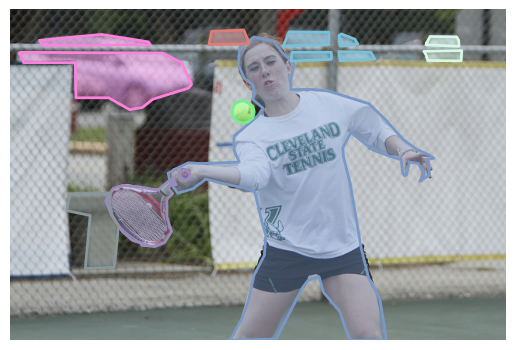

In [11]:
if not check_config_exists():
    # selected coco class names
    coco_class_names = ['sports ball', 'pizza', 'toaster', 'frisbee', 'clock', 'broccoli', 'apple', 'bench', 'handbag', 'giraffe']
    update_config('coco_selected_object_names', coco_class_names)
else:
    config = load_config()
    coco_class_names = config['coco_selected_object_names']

img_ids = get_img_ids_for_object_classes(coco,coco_class_names,img_cnt_per_obj_type)

# load and display a random image
img_id = img_ids[np.random.randint(0,len(img_ids))]
img = coco.loadImgs(img_id)[0]
I = io.imread(f'{data_dir}/images/train/{img["file_name"]}')/255.0

plt.axis('off')
plt.imshow(I)

annIds = coco.getAnnIds(imgIds=img_id,iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

plt.show()

In [12]:
# check total images
len(img_ids)

958

Total 960 images are found for object types 'sports ball', 'pizza', 'toaster', 'frisbee', 'clock', 'broccoli', 'apple', 'bench', 'handbag', 'giraffe' with a maximum of 100 per object type

Apply segmentation mask to loaded image

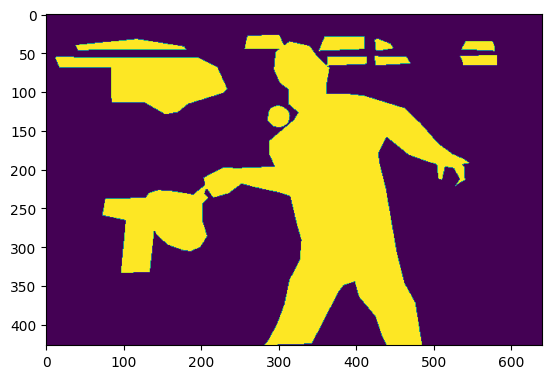

In [13]:
mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    mask = np.maximum(coco.annToMask(anns[i]), mask)
plt.imshow(mask)
plt.show()

Find objects that are in selected class names

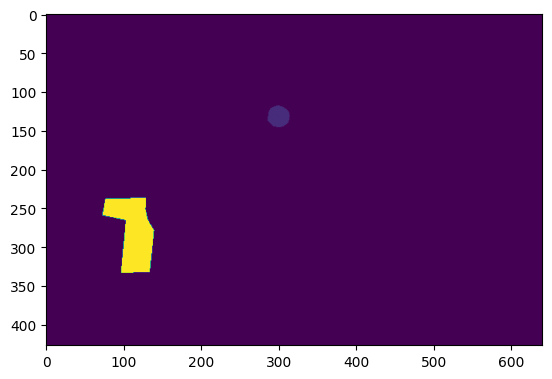

In [14]:
all_cat_ids = coco.getCatIds()
cats = coco.loadCats(all_cat_ids)
def get_class_name(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    className = get_class_name(anns[i]['category_id'], cats)
    if className in coco_class_names:
        pixel_value = coco_class_names.index(className)+1
        mask = np.maximum(coco.annToMask(anns[i])*pixel_value, mask)
plt.imshow(mask)
plt.show()

Load selected images

In [15]:
def load_img_obj_from_ids(img_ids: List[int], coco: COCO):
    # load selected images
    images = coco.loadImgs(img_ids)
        
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
                
    random.shuffle(unique_images)
    
    return unique_images

unique_images = load_img_obj_from_ids(img_ids, coco)

Subset COCO to only selected images to save computational resources

In [16]:
import shutil

def subset_data(mode: str):
    if not os.path.exists(f'{data_dir}/{mode}2017'):
        os.mkdir(f'{data_dir}/{mode}2017')
    else:
        return # already present
    
    ann_file=f'{data_dir}/annotations/all/instances_{mode}2017.json'
    coco=COCO(ann_file)
    
    img_ids = get_img_ids_for_object_classes(coco,coco_class_names,img_cnt_per_obj_type)
    update_config(f'{mode}_img_ids', img_ids)
    
    imgs = load_img_obj_from_ids(img_ids, coco)
    for img in imgs:
        shutil.copyfile(f'{data_dir}/images/{mode}/{img["file_name"]}', f'{data_dir}/{mode}2017/{img["file_name"]}')

subset_data('val')
subset_data('train')

loading annotations into memory...
Done (t=1.27s)
creating index...
index created!
loading annotations into memory...
Done (t=82.09s)
creating index...
index created!


In [17]:
def subset_ann(mode: str):
    ann_file=f'{data_dir}/annotations/all/instances_{mode}2017.json'
    with open(ann_file) as f:
        d = json.load(f)
        
    img_ids = load_config()[f'{mode}_img_ids']

    selected_objs = []
    for img in d['images']:
        if img['id'] in img_ids:
            selected_objs.append(img)

    d['images'] = selected_objs

    selected_objs = []
    coco=COCO(ann_file)
    id2label = {k: v['name'] for k,v in coco.cats.items() if v['name'] in coco_class_names}
    for i in img_ids:
        for a in coco.loadAnns(coco.getAnnIds(i)):
            if a['category_id'] in id2label:
                selected_objs.append(a)


    # for a in d['annotations']:
    #     if a['image_id'] in img_ids:
    #         selected_objs.append(a)

    d['annotations'] = selected_objs

    selected_objs = []
    filtered_cat_ids = []
    for obj_name in coco_class_names:
        filtered_cat_ids.append(coco.getCatIds(catNms=[obj_name])[0])

    filtered_cat_ids = list(set(filtered_cat_ids))
    for c in d['categories']:
        if c['id'] in filtered_cat_ids:
            selected_objs.append(c)

    d['categories'] = selected_objs
    
    with open(f'{data_dir}/annotations/instances_{mode}2017.json', 'w') as f:
        json.dump(d, f)


subset_ann('val')
subset_ann('train')

loading annotations into memory...
Done (t=1.31s)
creating index...
index created!
loading annotations into memory...
Done (t=141.85s)
creating index...
index created!


Load random image converted to grayscale

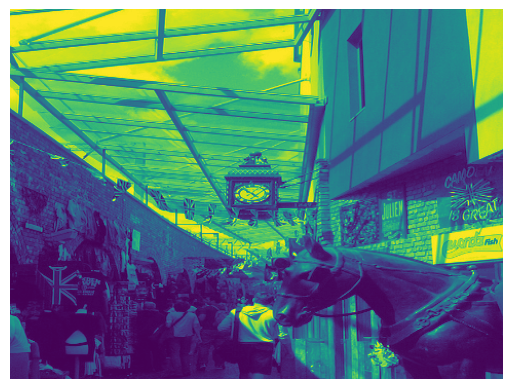

In [18]:
# helper function to load image into memory
def get_image(image_obj: Dict, img_folder: str, input_image_size: Tuple[int,int], maintain_aspect_ratio: bool = False):
    # Read and normalize an image
    img = io.imread(f'{img_folder}/{image_obj["file_name"]}', as_gray=True)/255.0
    
    if maintain_aspect_ratio:
        # maintain aspect ratio
        height_percent = (input_image_size[0] / float(image_obj['height']))
        width = int((float(image_obj['width']) * float(height_percent)))
        input_image_size = (input_image_size[0], width)
    
    # Resize
    img = cv2.resize(img, input_image_size)
    
    return img

plt.imshow(get_image(unique_images[np.random.randint(len(unique_images))], 
                     f'{data_dir}/images/train', (480,256), True))
plt.axis('off')
plt.show()

## Data processing

Data generator to load images in batches

In [ ]:
def get_normal_mask(image_obj: Dict, classes: List, coco: COCO, cat_ids: List, input_image_size: Tuple):
    annIds = coco.getAnnIds(image_obj['id'], catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(cat_ids)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        class_name = find_category_with_id(
            anns[a]['category_id'], cats)['name']
        pixel_value = classes.index(class_name)+1
        new_mask = cv2.resize(coco.annToMask(
            anns[a])*pixel_value, input_image_size)
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(
        input_image_size[0], input_image_size[1], 1)
    return train_mask


def get_binary_mask(image_obj: Dict, coco: COCO, cat_ids: List, input_image_size: Tuple):
    annIds = coco.getAnnIds(image_obj['id'], catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(annIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        new_mask = cv2.resize(coco.annToMask(anns[a]), input_image_size)

        # Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0

        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(
        input_image_size[0], input_image_size[1], 1)
    return train_mask


def dataGeneratorCoco(images: List, classes: List, coco: COCO, img_folder: str,
                      input_image_size=(224, 224), batch_size=4, mode='train', mask_type='binary'):

    dataset_size = len(images)
    cat_ids = coco.getCatIds(catNms=classes)

    c = 0
    while (True):
        img = np.zeros(
            (batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros(
            (batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

        for i in range(c, c+batch_size):  # initially from 0 to batch_size, when c = 0
            imageObj = images[i]

            # Get image
            train_img = get_image(imageObj, img_folder, input_image_size)

            # Create Mask
            if mask_type == "binary":
                train_mask = get_binary_mask(
                    imageObj, coco, cat_ids, input_image_size)

            elif mask_type == "normal":
                train_mask = get_normal_mask(
                    imageObj, classes, coco, cat_ids, input_image_size)

            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask

        c += batch_size
        if (c + batch_size >= dataset_size):
            c = 0
            random.shuffle(images)

        yield img, mask


In [ ]:
batch_size = 4
input_image_size = (224,224)
mask_type = 'binary'

val_gen = dataGeneratorCoco(unique_images, coco_class_names, coco, f'{data_dir}/images/train', 
                            input_image_size, batch_size, 'train', mask_type)

Helper function to visualize generator output

In [ ]:
def visualize_generator(gen):
    # Iterate the generator to get image and mask batches
    img, mask = next(gen)
 
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
   
    for i in range(2):        
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j]);
            else:
                ax.imshow(mask[j][:,:,0]);
                
            ax.axis('off')
            fig.add_subplot(ax)
    plt.show()

visualize_generator(val_gen)

Wrapper on keras ImageDataGenerator to generate augmentations

In [ ]:
def augmentations_generator(gen, aug_generator_args, seed=None):
    # Initialize the image data generator with args provided
    image_gen = ImageDataGenerator(**aug_generator_args)
    
    # Remove the brightness argument for the mask. Spatial arguments similar to image.
    augGeneratorArgs_mask = aug_generator_args.copy()
    _ = augGeneratorArgs_mask.pop('brightness_range', None)
    # Initialize the mask data generator with modified args
    mask_gen = ImageDataGenerator(**augGeneratorArgs_mask)
    
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    
    for img, mask in gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation of the images 
        # will end up different from the augmentation of the masks
        g_x = image_gen.flow(255*img, 
                             batch_size = img.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = mask_gen.flow(mask, 
                             batch_size = mask.shape[0], 
                             seed = seed, 
                             shuffle=True)
        
        img_aug = next(g_x)/255.0
        
        mask_aug = next(g_y)
                   

        yield img_aug, mask_aug

In [ ]:
augGeneratorArgs = dict(featurewise_center = False, 
                        samplewise_center = False,
                        rotation_range = 5, 
                        width_shift_range = 0.01, 
                        height_shift_range = 0.01, 
                        brightness_range = (0.8,1.2),
                        shear_range = 0.01,
                        zoom_range = [1, 1.25],  
                        horizontal_flip = True, 
                        vertical_flip = False,
                        fill_mode = 'reflect',
                        data_format = 'channels_last')

aug_gen = augmentations_generator(val_gen, augGeneratorArgs)
visualize_generator(aug_gen)

## DETR Fork

In [19]:
epochs = 1

In [20]:
# !rm -rf detr
!git clone https://github.com/ahmfrz/detr.git
%cd detr

c:\Code\datascience\augmented_detr\src\notebooks\detr


fatal: destination path 'detr' already exists and is not an empty directory.


In [25]:
!python main.py --num_queries 10 --coco_path "..\data\coco" --output_dir "..\output" --backbone "resnet50" --epochs 1 --device "cpu"

In [ ]:
from util.plot_utils import plot_logs

from pathlib import Path

log_directory = [Path('../outputs/')]
     

In [ ]:
fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs(log_directory,
          fields_of_interest)

In [ ]:
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )

plot_logs(log_directory,
          fields_of_interest)

In [ ]:

fields_of_interest = (
    'class_error',
    'cardinality_error_unscaled',
    )

plot_logs(log_directory,
          fields_of_interest)   

In [ ]:

model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=len(coco_class_names))

checkpoint = torch.load('../outputs/checkpoint.pth',
                        map_location='cpu')

model.load_state_dict(checkpoint['model'],
                      strict=False)

model.eval();

DETR implementation

In [ ]:
data_dir='./data/coco/'
data_dir=os.path.abspath(data_dir)
ann_file=f'{data_dir}/annotations/instances_train2017.json'

In [ ]:

import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, feature_extractor):
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension
        
        return pixel_values, target
     

In [ ]:
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor()#.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder=f'{data_dir}/images/train/', 
                              ann_file=f'{data_dir}/annotations/instances_train2017.json',
                              feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder=f'{data_dir}/images/val/', 
                              ann_file=f'{data_dir}/annotations/instances_val2017.json',
                              feature_extractor=feature_extractor)

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

In [ ]:
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
# let's pick a random image
image_ids = train_dataset.coco.getImgIds()
image_id = image_ids[np.random.randint(0, len(image_ids))]

print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(f'{data_dir}/images/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  class_idx = annotation['category_id']
  if id2label[class_idx] in coco_class_names:
    box = annotation['bbox']
    x,y,w,h = tuple(box)
    draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
    draw.text((x, y), id2label[class_idx], fill='white')

image
     

In [ ]:
len(id2label)

In [ ]:
for i in annotations:
    print(i['category_id'], i['id'])

In [ ]:
id2label = {k: v['name'] for k,v in cats.items() if v['name']}# in coco_class_names}
# id2label[12] = 'stop sign'
# id2label[29] = 'handbag'
# id2label[68] = 'toilet'
# id2label[69] = 'toilet'
# id2label[71] = 'tv'
len(id2label)

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import Sampler, SubsetRandomSampler

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

class SubsetSampler(Sampler):
  def __init__(self, indices):
        self.indices = indices

  def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

  def __len__(self):
        return len(self.indices)

def get_selected_image_indices(dataset, img_ids):
      idx = []
      for i, v in enumerate(list(sorted(dataset.coco.imgs.keys()))):
            if v in img_ids:
                  idx.append(i)
      return idx

# train_sampler = SubsetRandomSampler(get_selected_image_indices(train_dataset, load_config()['train_img_ids']))
# val_sampler = SubsetRandomSampler(get_selected_image_indices(val_dataset, load_config()['val_img_ids']))

# train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, sampler=train_sampler, batch_size=2)
# val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, sampler=val_sampler, batch_size=2)

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=2)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)

In [ ]:

batch = next(iter(train_dataloader))
batch.keys()
     

In [ ]:
batch['pixel_values'].shape, batch['pixel_mask'].shape

Model Training

In [ ]:
import pytorch_lightning as pl
from transformers import DetrConfig, DetrForObjectDetection
import torch

class Detr(pl.LightningModule):

     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         self.model = DetrForObjectDetection(DetrConfig(num_of_channels=1, num_of_queries=10))#.from_pretrained("facebook/detr-resnet-50", 
                                                           #  num_labels=len(id2label),
                                                            # ignore_mismatched_sizes=True)
         # # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs
     
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/

In [ ]:

model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

In [ ]:
outputs.logits.shape

In [ ]:
from pytorch_lightning import Trainer

trainer = Trainer(max_steps=1, gradient_clip_val=0.1)
trainer.fit(model)

In [ ]:
! git clone https://github.com/facebookresearch/detr.git
%cd detr

In [ ]:
os.getcwd()

In [ ]:
from datasets import get_coco_api_from_dataset
from datasets.coco_eval import CocoEvaluator

base_ds = get_coco_api_from_dataset(val_dataset) # this is actually just calling the coco attribute
iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types) # initialize evaluator with ground truths
     

In [ ]:
from transformers import DetrForObjectDetection

# model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

In [ ]:
from datasets.coco_eval import CocoEvaluator
from tqdm.notebook import tqdm
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

print("Running evaluation...")

# let's limit the number of batches for now
nbatches = 5
for idx, batch in enumerate(tqdm(val_dataloader)):
    
    if idx > nbatches:
        break
    
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process(outputs, orig_target_sizes) # convert outputs to COCO api
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)

In [ ]:
coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

In [ ]:
#We can use the image_id in target to know which image it is
pixel_values, target = val_dataset[1]

In [ ]:
pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)

In [ ]:
# forward pass to get class logits and bounding boxes
outputs = model(pixel_values=pixel_values, pixel_mask=None)

In [ ]:
import torch
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
def visualize_predictions(image, outputs, threshold=0.9):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  
  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

  # plot results
  plot_results(image, probas[keep], bboxes_scaled)

In [ ]:
def visualize_predictions(image, outputs, threshold=0.9):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  
  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

  # plot results
  plot_results(image, probas[keep], bboxes_scaled)

In [ ]:
os.path.join(f'{data_dir}/images/train', image['file_name'])

In [ ]:
image_id = target['image_id'].item()
image = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(f'{data_dir}/images/val', image['file_name']))

visualize_predictions(image, outputs)